## Stability Evaluation
> Author: Tianyu Lin
>
> Email: linty6@mail2.sysu.edu.cn
> 
> Date: Mar 2, 2024

### Introduction
Evaluate the stability of segmentation results of diffusion-based segmentation models.

### Metrics
1. FID(deleted) & LPIPS: calculate between each set of predictions of the whole test dataset. 
2. SSIM & MS-SSIM & PSNR: calculate between each predictions of a fixed image in test dataset.

### GPU Memory Requirements
> Calculate the metrics on cuda for acceleration.

For BTCV slices (with non-empty label, 847 images x 10), requires 6GB == 3GB (for data) + 3GB (for LPIPS model with batch_size 50).

### Notes
- Reults to be estimated should not contain empty prediction.
- Put your results as:
```bash
outputs/
├── slice2seg-samples-dataset_name
│   ├── seed1
│   │   ├── file1-gts.png
│   │   ├── file2-gts.png
│   │   ├── file3-gts.png
│   │   ├── ...
│   ├── seed2
│   │   ├── file1-gts.png
│   │   ├── file2-gts.png
│   │   ├── file3-gts.png
│   │   ├── ...
│   ├── ...
```
And modify the 'paths' in the "Preparation" code block if needed.

### Imports


In [1]:

import matplotlib.pyplot as plt
plt.style.use("seaborn")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
if 'LD_LIBRARY_PATH' not in os.environ:
    os.environ["LD_LIBRARY_PATH"] = f"/GPUFS/nsccgz_ywang_zfd/.conda/envs/ldm/lib"
else:
    os.environ["LD_LIBRARY_PATH"] = f"/GPUFS/nsccgz_ywang_zfd/.conda/envs/ldm/lib:{os.environ['LD_LIBRARY_PATH']}"
print(os.environ["LD_LIBRARY_PATH"])

import torch
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
# from torchmetrics.image.fid import FrechetInceptionDistance as FID
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure as MSSSIM
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm

/GPUFS/nsccgz_ywang_zfd/.conda/envs/ldm/lib


/GPUFS/nsccgz_ywang_zfd/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare data for evaluation

In [2]:
class LPIPSDataset(Dataset):    # cut dataset to batches for LPIPS model
    def __init__(self, data_list) -> None:
        super().__init__()
        self.data_list = data_list
    def __getitem__(self, idx):
        return self.data_list[idx]
    def __len__(self):
        return self.data_list.shape[0]
    
    
"""Set parameters & paths"""
plot = False    # plot metric values curve
eval_path = "../outputs/slice2seg-samples-synapse-b"  # SDSeg
# eval_path = "/GPUFS/nsccgz_ywang_zfd/LinTianyu/Internship/Diff-UNet-main/BTCV/logs_btcv/compare"    # Diff-UNet
# eval_path = "/GPUFS/nsccgz_ywang_zfd/LinTianyu/Internship/MedSegDiff-master/results/BTCV_test/dpmsolver_50_10_save" # MedSegDiff-V2


"""Parse image paths"""
seed_folders = glob.glob(os.path.join(eval_path, "[0-9]"))  # seed 0 to 9
path_array = np.asarray(list(map(lambda x: glob.glob(os.path.join(x, "*-logits*")), seed_folders)))    # *-gts contains only non-empty target slice
num_samples, num_test_set = path_array.shape
print(f"(seeds, samples) = {num_samples, num_test_set}")


"""Loading all images"""
pred_array = list()
for path in tqdm(path_array.flatten(), desc="Loading images"):
    pred_array.append(np.asarray(Image.open(path).convert("RGB")))
pred_array = np.asarray(pred_array)
image_shape = pred_array.shape[1:]  # h w c
pred_array = torch.from_numpy(
    np.asarray(pred_array).reshape(num_samples, num_test_set, *image_shape)
    )
pred_array = pred_array.permute(0, 1, 4, 2, 3).cuda()


"""for LPIPS:  each element refers to one time of inference on the test set"""
pred_test_set_list = list()
for idx in tqdm(range(num_samples), desc="Preparing list per test set"):
    pred_test_set_list.append(pred_array[idx])
print(len(pred_test_set_list), pred_test_set_list[0].shape, pred_test_set_list[0].dtype, pred_test_set_list[0].min(), pred_test_set_list[0].max())


"""for SSIM & PNSR & MS-SSIM:  each element refers to several samples on an single imagepred_test_set_list = list()"""
pred_samples_list = list()
for idx in tqdm(range(num_test_set), desc="Preparing list per cond"):
    pred_samples_list.append(pred_array[:, idx])
print(len(pred_samples_list), pred_samples_list[0].shape, pred_samples_list[0].dtype, pred_samples_list[0].min(), pred_samples_list[0].max())

(seeds, samples) = (10, 847)


Preparing list per test set: 100%|██████████| 10/10 [00:00<00:00, 86659.17it/s]


10 torch.Size([847, 3, 256, 256]) torch.uint8 tensor(0, device='cuda:0', dtype=torch.uint8) tensor(255, device='cuda:0', dtype=torch.uint8)


Preparing list per cond: 100%|██████████| 847/847 [00:00<00:00, 318959.91it/s]

847 torch.Size([10, 3, 256, 256]) torch.uint8 tensor(0, device='cuda:0', dtype=torch.uint8) tensor(255, device='cuda:0', dtype=torch.uint8)


### MS-SSIM

In [3]:

msssim = MSSSIM()   # input: (N, 3, H, W)
msssim.cuda()

with torch.no_grad():
    msssim_values = list()
    pbar = tqdm(pred_samples_list, desc="MS-SSIM Evaluation")
    for pred_per_cond in pbar:  
        if pred_per_cond[0:1].sum()==0:     # prevent Division by Zero 
            continue
        msssim_per_cond = list() 
        for i in range(1, num_samples):
            if pred_per_cond[i:i+1].sum()==0:   # prevent Division by Zero 
                continue
            msssim.update(pred_per_cond[i:i+1].float(), pred_per_cond[0:1].float())
            msssim_i = msssim.compute().cpu()
            msssim.reset()

            msssim_per_cond.append(msssim_i)

        if len(msssim_per_cond) > 0:    
            msssim_per_cond = np.asarray(msssim_per_cond)
            msssim_values.append(msssim_per_cond.mean())
        else:
            continue

        pbar.set_postfix(MS_SSIM_per_cond=msssim_per_cond.mean())

msssim_values = np.asarray(msssim_values)
msssim.cpu()

print(f"\033[31m mean MS-SSIM = {msssim_values.mean()}\033[0m")

if plot:
    plt.plot(msssim_values, "o-")
    plt.show()
    plt.clf()


/GPUFS/nsccgz_ywang_zfd/.conda/envs/ldm/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `MS_SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
MS-SSIM Evaluation: 100%|██████████| 847/847 [00:33<00:00, 25.63it/s, MS_SSIM_per_cond=0.993]

 mean MS-SSIM = 0.9855666160583496


### SSIM score

In [4]:
ssim = SSIM()   # input: (N, 3, H, W)
ssim.cuda()

with torch.no_grad():
    ssim_values = list()
    pbar = tqdm(pred_samples_list, desc="SSIM Evaluation")
    for pred_per_cond in pbar:  
        if pred_per_cond[0:1].sum()==0:     # prevent Division by Zero 
            continue
        ssim_per_cond = list() 
        for i in range(1, num_samples):
            if pred_per_cond[i:i+1].sum()==0:   # prevent Division by Zero 
                continue
            ssim.update(pred_per_cond[i:i+1].float(), pred_per_cond[0:1].float())
            ssim_i = ssim.compute().cpu()
            ssim.reset()

            ssim_per_cond.append(ssim_i)
        if len(ssim_per_cond) > 0:
            ssim_per_cond = np.asarray(ssim_per_cond)
            ssim_values.append(ssim_per_cond.mean())
        else:
            continue

        pbar.set_postfix(SSIM_per_cond=ssim_per_cond.mean())

ssim_values = np.asarray(ssim_values)
ssim.cpu()


print(f"\033[31m mean SSIM = {ssim_values.mean()}\033[0m")

if plot:
    plt.plot(ssim_values, "o-")
    plt.show()
    plt.clf()


/GPUFS/nsccgz_ywang_zfd/.conda/envs/ldm/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
SSIM Evaluation: 100%|██████████| 847/847 [00:09<00:00, 92.10it/s, SSIM_per_cond=0.922] 

 mean SSIM = 0.9450787305831909


### PSNR score

In [5]:

psnr = PSNR()   # input: (N, 3, H, W)
psnr.cuda()

with torch.no_grad():
    psnr_values = list()
    pbar = tqdm(pred_samples_list, desc="PSNR Evaluation")
    for pred_per_cond in pbar:  
        if pred_per_cond[0:1].sum()==0:     # prevent Division by Zero 
            continue
        psnr_per_cond = list() 
        for i in range(1, num_samples):
            if pred_per_cond[i:i+1].sum()==0:   # prevent Division by Zero 
                continue
            if (pred_per_cond[i:i+1] == pred_per_cond[0:1]).all():  # prevent Infinate
                continue
            psnr.update(pred_per_cond[i:i+1].float(), pred_per_cond[0:1].float())
            psnr_i = psnr.compute().cpu()
            psnr.reset()

            psnr_per_cond.append(psnr_i)
        if len(psnr_per_cond) > 0:
            psnr_per_cond = np.asarray(psnr_per_cond)
            psnr_values.append(psnr_per_cond.mean())
        else:
            continue


        pbar.set_postfix(PSNR_per_cond=sum(psnr_per_cond)/len(psnr_per_cond))
    
psnr.cpu()
psnr_values = np.asarray(psnr_values)


print(f"\033[31m mean PSNR = {psnr_values.mean()}\033[0m")

if plot:
    plt.plot(psnr_values, "o-")
    plt.show()
    plt.clf()


PSNR Evaluation: 100%|██████████| 847/847 [00:06<00:00, 129.19it/s, PSNR_per_cond=28.5]

 mean PSNR = 30.076366424560547


### LPIPS socre

In [6]:
lpips = LPIPS() # input: (N, 3, H, W), [-1, 1], float32
lpips.cuda()

with torch.no_grad():
    lpips_values = list()
    pbar = tqdm(pred_test_set_list[1:], desc="LPIPS Evaluation")
    for pred_test_set in pbar:
        pred_reference = (pred_test_set_list[0]/255.) *2-1
        pred_set = (pred_test_set/255.) *2-1

        pred_reference_dataloader = DataLoader(LPIPSDataset(pred_reference), batch_size=50, shuffle=False, drop_last=False)
        pred_set_dataloader = DataLoader(LPIPSDataset(pred_set), batch_size=50, shuffle=False, drop_last=False)
        lpips_values_per_test = list()
        for pred_reference_batch, pred_set_batch in zip(pred_reference_dataloader, pred_set_dataloader):
            lpips.update(pred_reference_batch, pred_set_batch)
            lpips_score = lpips.compute().cpu() 
            lpips.reset()
            lpips_values_per_test.append(lpips_score)
        lpips_values_per_test_mean = np.asarray(lpips_values_per_test).mean()
        lpips_values.append(lpips_values_per_test_mean)
        pbar.set_postfix(dict(lpips_score=lpips_values_per_test_mean))

lpips.cpu()


print(f"\033[31m mean LPIPS = {sum(lpips_values)/len(lpips_values)}\033[0m")

if plot:
    plt.plot(lpips_values, "o-")
    plt.show()
    plt.clf()


LPIPS Evaluation: 100%|██████████| 9/9 [00:03<00:00,  2.37it/s, lpips_score=0.0225]

 mean LPIPS = 0.021929613625009853


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


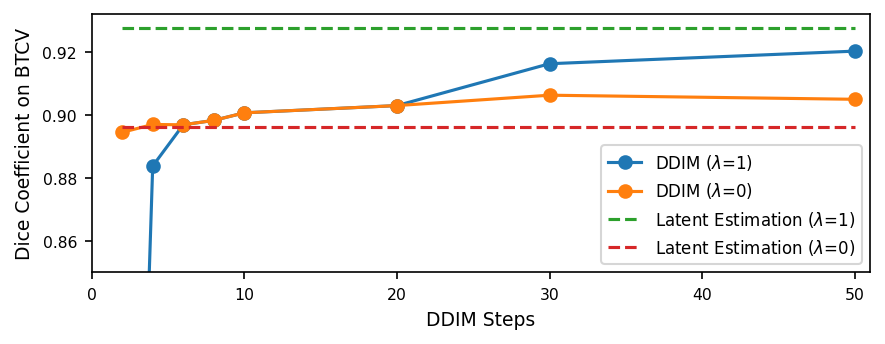

<Figure size 640x480 with 0 Axes>

In [1]:
# cvc
import numpy as np
import matplotlib.pyplot as plt
styles = plt.style.available
# plt.style.use("seaborn")


plt.figure(figsize=(6, 2.4), dpi=150)
ddim_steps = np.array([2, 4, 6, 8, 10, 20, 30, 50])
ddim_dice_1 = np.array([0.5843, 0.8837, 0.8968, 0.8982, 0.9006, 0.9029, 0.9162, 0.9202])
ddim_dice_0 = np.array([0.8944, 0.8969, 0.8968, 0.8982, 0.9006, 0.9029, 0.9062, 0.9049])
plt.plot(ddim_steps, ddim_dice_1, "o-", label="DDIM ($\lambda$=1)")
plt.plot(ddim_steps, ddim_dice_0, "o-", label="DDIM ($\lambda$=0)")
plt.plot([ddim_steps[0], ddim_steps[-1]], [0.9276, 0.9276], "--", label="Latent Estimation ($\lambda$=1)")
plt.plot([ddim_steps[0], ddim_steps[-1]], [0.8962, 0.8962], "--", label="Latent Estimation ($\lambda$=0)")
plt.xlabel("DDIM Steps", fontdict=dict(fontsize=9))
plt.ylabel("Dice Coefficient on BTCV", fontdict=dict(fontsize=9))
plt.xlim(0, 51)
plt.ylim(0.85, 0.932)
plt.legend(frameon=True, loc="lower right", fontsize=8)
plt.xticks(fontsize=7.5)
plt.yticks(fontsize=7.5)

plt.tight_layout()
plt.grid(False)
plt.savefig("ReverseCurve.eps")
plt.show()
plt.clf()



In [8]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']